**Assignment #2: Write up a report that makes use of Covid Positive X-Ray image data.**

**GitHub Link: https://github.com/Bobbie8881/Projects-in-ML**

**Citation of paper providing original dataset:**  M.E.H. Chowdhury, T. Rahman, A. Khandakar, R. Mazhar, M.A. Kadir, Z.B. Mahbub, K.R. Islam, M.S. Khan, A. Iqbal, N. Al-Emadi, M.B.I. Reaz, “Can AI help in screening Viral and COVID-19 pneumonia?” arXiv preprint, 29 March 2020, https://arxiv.org/abs/2003.13145


In [1]:
# Connect to google drive
import os
from google.colab import drive
drive.mount('/content/drive')

# content in your drive is now available via "/content/drive/My Drive"


Mounted at /content/drive


In [2]:
# Import data and unzip files to folder
!unzip /content/drive/MyDrive/COVID-19_Radiography_Dataset.zip

串流輸出內容已截斷至最後 5000 行。
  inflating: COVID-19_Radiography_Dataset/Normal/masks/Normal-7924.png  
  inflating: COVID-19_Radiography_Dataset/Normal/masks/Normal-7925.png  
  inflating: COVID-19_Radiography_Dataset/Normal/masks/Normal-7926.png  
  inflating: COVID-19_Radiography_Dataset/Normal/masks/Normal-7927.png  
  inflating: COVID-19_Radiography_Dataset/Normal/masks/Normal-7928.png  
  inflating: COVID-19_Radiography_Dataset/Normal/masks/Normal-7929.png  
  inflating: COVID-19_Radiography_Dataset/Normal/masks/Normal-793.png  
  inflating: COVID-19_Radiography_Dataset/Normal/masks/Normal-7930.png  
  inflating: COVID-19_Radiography_Dataset/Normal/masks/Normal-7931.png  
  inflating: COVID-19_Radiography_Dataset/Normal/masks/Normal-7932.png  
  inflating: COVID-19_Radiography_Dataset/Normal/masks/Normal-7933.png  
  inflating: COVID-19_Radiography_Dataset/Normal/masks/Normal-7934.png  
  inflating: COVID-19_Radiography_Dataset/Normal/masks/Normal-7935.png  
  inflating: COVID-19_Radiograp

In [3]:
# Load libraries and then download data

import sys
import time
import cv2
import numpy as np
from matplotlib import pyplot as plt
import tensorflow as tf
import os
import zipfile

from sklearn.model_selection import train_test_split

from tensorflow.python.keras.utils import np_utils
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Flatten, Activation, BatchNormalization, GlobalAveragePooling2D
from tensorflow.python.keras.layers.convolutional import Conv2D, MaxPooling2D 
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam,SGD,Adagrad,Adadelta,RMSprop
from tensorflow.keras.applications import VGG19, ResNet50, InceptionV3


In [4]:
# Extracting all filenames iteratively
base_path = 'COVID-19_Radiography_Dataset'
categories = ['COVID/images', 'Normal/images', 'Viral Pneumonia/images']

# load file names to fnames list object
fnames = []
for category in categories:
    image_folder = os.path.join(base_path, category)
    file_names = os.listdir(image_folder)
    full_path = [os.path.join(image_folder, file_name) for file_name in file_names]
    fnames.append(full_path)

print('number of images for each category:', [len(f) for f in fnames])
print(fnames[0:2]) #examples of file names

number of images for each category: [3616, 10192, 1345]
[['COVID-19_Radiography_Dataset/COVID/images/COVID-30.png', 'COVID-19_Radiography_Dataset/COVID/images/COVID-722.png', 'COVID-19_Radiography_Dataset/COVID/images/COVID-2252.png', 'COVID-19_Radiography_Dataset/COVID/images/COVID-3218.png', 'COVID-19_Radiography_Dataset/COVID/images/COVID-2202.png', 'COVID-19_Radiography_Dataset/COVID/images/COVID-1438.png', 'COVID-19_Radiography_Dataset/COVID/images/COVID-1348.png', 'COVID-19_Radiography_Dataset/COVID/images/COVID-3026.png', 'COVID-19_Radiography_Dataset/COVID/images/COVID-3169.png', 'COVID-19_Radiography_Dataset/COVID/images/COVID-2258.png', 'COVID-19_Radiography_Dataset/COVID/images/COVID-3349.png', 'COVID-19_Radiography_Dataset/COVID/images/COVID-1440.png', 'COVID-19_Radiography_Dataset/COVID/images/COVID-2317.png', 'COVID-19_Radiography_Dataset/COVID/images/COVID-3192.png', 'COVID-19_Radiography_Dataset/COVID/images/COVID-2546.png', 'COVID-19_Radiography_Dataset/COVID/images/CO

In [5]:
#Reduce number of images to first 1345 for each category
fnames[0]=fnames[0][0:1344]
fnames[1]=fnames[1][0:1344]
fnames[2]=fnames[2][0:1344]

In [6]:
# Import image, load to array of shape height, width, channels, then min/max transform.
# Write preprocessor that will match up with model's expected input shape.
from keras.preprocessing import image
import numpy as np
from PIL import Image

def preprocessor(img_path):
        img = Image.open(img_path).convert("RGB").resize((192,192)) # import image, make sure it's RGB and resize to height and width you want.
        img = (np.float32(img)-1.)/(255-1.) # min max transformation
        img=img.reshape((192,192,3)) # Create final shape as array with correct dimensions for Keras
        return img



#Try on single flower file (imports file and preprocesses it to data with following shape)
preprocessor('COVID-19_Radiography_Dataset/COVID/images/COVID-2273.png').shape

(192, 192, 3)

In [7]:
#Import image files iteratively and preprocess them into array of correctly structured data

# Create list of file paths
image_filepaths=fnames[0]+fnames[1]+fnames[2]

# Iteratively import and preprocess data using map function

# map functions apply your preprocessor function one step at a time to each filepath
preprocessed_image_data=list(map(preprocessor,image_filepaths ))

# Object needs to be an array rather than a list for Keras (map returns to list object)
X= np.array(preprocessed_image_data) # Assigning to X to highlight that this represents feature input data for our model

In [8]:
# Create y data made up of correctly ordered labels from file folders
from itertools import repeat

# Recall that we have five folders with the following number of images in each folder 
#...corresponding to each flower type

covid=list(repeat("COVID", 1344))
normal=list(repeat("NORMAL", 1344))
pneumonia=list(repeat("PNEUMONIA", 1344))

#combine into single list of y labels
y_labels = covid+normal+pneumonia


# Need to one hot encode for Keras.  Let's use Pandas

import pandas as pd
y=pd.get_dummies(y_labels)


**Visualize images that demonstrate when x-rays demonstrate Covid Positivity and when they do not (You can present visuals of each category in the data if you would like to.).**

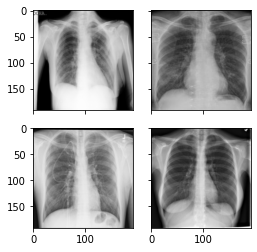

In [9]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
import numpy as np
import random

im1 =preprocessor(fnames[0][0])
im2 =preprocessor(fnames[0][100])
im3 =preprocessor(fnames[1][1])
im4 =preprocessor(fnames[1][100])

fig = plt.figure(figsize=(4., 4.))
grid = ImageGrid(fig, 111,  # similar to subplot(111)
                 nrows_ncols=(2, 2),  # creates 2x2 grid of axes
                 axes_pad=0.25,  # pad between axes in inch.
                 )

for ax, im in zip(grid, [im1, im2, im3, im4]):
    # Iterating over the grid returns the Axes.
    ax.imshow(im)
plt.show()

Images 1 and 2 (top left and right) demonstrate when x-rays demonstrate Covid Positivity. Images 3 and 4 (down left and right) demonstrate when x-rays do not demonstrate Covid Positivity.

**Discuss the dataset in general terms and describe why building a predictive model using this data might be practically useful. Who could benefit from a model like this? Explain.**

The COVID-19 Radiography Dataset is a collection of chest X-ray pictures taken of COVID-19 patients as well as healthy people and people with various respiratory conditions.

Building a predictive model using this data might be practically useful in a number of ways. First, it can aid in the automation of the COVID-19 diagnosing process, which can lighten the strain of medical personnel and quicken the testing procedure. Second, the predictive model can help identify COVID-19 patients who require urgent medical attention. The prediction model can assist in finding patterns and characteristics that are suggestive of severe COVID-19 instances by examining X-ray pictures.

Healthcare professionals, public health officials, legislators, and patients, may find practical utility in a predictive model based on the COVID-19 Radiography Dataset. It could assist in automating the COVID-19 diagnosis process, enhancing diagnosis accuracy, identifying high-risk patients, and tracking the disease's course in specific patients.

**Run at least three prediction models to try to predict x-ray images well.**


* Use transfer learning for at least one of these models
* Discuss which models performed better and point out relevant hyper-parameter values for successful models.
* Submit your best three models to the leader board for the Covid X-ray Diagnostic AI Model Share competition.

In [10]:
# ======Train test split resized images (Hackathon Note!! Use same train test split to be able to submit predictions to leaderboard!)=======================================
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y, test_size = 0.32, random_state = 1987)


X_test.shape, y_test.shape

((1291, 192, 192, 3), (1291, 3))

In [11]:
#Clear objects from memory
del(X)
del(y)
del(preprocessed_image_data)

In [12]:
#Save data to be able to reload quickly if memory crashes or if you run Runtime>Restart Runtime
import pickle

# Open a file and use dump()
with open('X_train.pkl', 'wb') as file:
    # A new file will be created
    pickle.dump(X_train, file)

#Save data
import pickle

# Open a file and use dump()
with open('X_test.pkl', 'wb') as file:
    # A new file will be created
    pickle.dump(X_test, file)

#Save data
import pickle

# Open a file and use dump()
with open('y_train.pkl', 'wb') as file:
    # A new file will be created
    pickle.dump(y_train, file)


# Open a file and use dump()
with open('y_test.pkl', 'wb') as file:
    # A new file will be created
    pickle.dump(y_test, file)

In [15]:
# Begin to submit models to image classification leaderboard
! pip install aimodelshare --upgrade
# Restart session Runtime > Restart runtime

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 967.8/967.8 KB 16.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 96.3/96.3 KB 12.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 280.2/280.2 KB 29.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.0/5.0 MB 74.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 511.8/511.8 MB 3.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 322.5/322.5 KB 37.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.7/132.7 KB 15.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 147.0/147.0 KB 16.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.0/294.0 KB 30.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.1/13.1 MB 89.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 442.3/44

**Model 1: CNN with Multiple Layers (epochs = 10)**

In [13]:
import tensorflow as tf

with tf.device('/device:GPU:0'): #"/GPU:0": Short-hand notation for the first GPU of your machine that is visible to TensorFlow.

  model = tf.keras.Sequential([
    # input: images of size Sample size, height, width, channels 1x192x192x3 pixels (the three stands for RGB channels)    
    tf.keras.layers.Conv2D(kernel_size=3, filters=32, padding='same', activation='relu', input_shape=(192, 192, 3)),
    tf.keras.layers.Conv2D(kernel_size=1, filters=32, padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=2),
    tf.keras.layers.Conv2D(kernel_size=3, filters=64, padding='same', activation='relu'),
    tf.keras.layers.Conv2D(kernel_size=1, filters=64, padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=2),
    tf.keras.layers.Conv2D(kernel_size=3, filters=128, padding='same', activation='relu'),
    tf.keras.layers.Conv2D(kernel_size=1, filters=128, padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=2),
    tf.keras.layers.Conv2D(kernel_size=3, filters=512, padding='same', activation='relu'),
    tf.keras.layers.Conv2D(kernel_size=1, filters=512, padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=2),
    tf.keras.layers.Conv2D(kernel_size=3, filters=512, padding='same', activation='relu'),
    tf.keras.layers.Conv2D(kernel_size=1, filters=512, padding='same', activation='relu'),
    tf.keras.layers.Flatten(),
    # classifying into 5 categories
    tf.keras.layers.Dense(3, activation='softmax')
  ])
  from tensorflow.python.keras.callbacks import ReduceLROnPlateau
  red_lr= ReduceLROnPlateau(monitor='val_acc',patience=3,verbose=1,factor=0.1) # dividing lr by 10 when val_accuracy fails to improve after 3 epochs

  model.compile(
    optimizer="adam", # to use callback set lr arg such as Adam(lr=0.001) instead
    loss= 'categorical_crossentropy',
    metrics=['accuracy'])
  
  # Fitting the CNN to the Training set
  model.fit(X_train, y_train, 
                    epochs = 10, verbose=1,validation_split=.2, callbacks=[red_lr])

Epoch 1/10
69/69 [==============================] - ETA: 0s - loss: 0.9522 - accuracy: 0.4827

69/69 [==============================] - 24s 130ms/step - loss: 0.9522 - accuracy: 0.4827 - val_loss: 0.6783 - val_accuracy: 0.7158 - lr: 0.0010
Epoch 2/10
68/69 [============================>.] - ETA: 0s - loss: 0.6141 - accuracy: 0.7289

69/69 [==============================] - 6s 87ms/step - loss: 0.6139 - accuracy: 0.7286 - val_loss: 0.5339 - val_accuracy: 0.7668 - lr: 0.0010
Epoch 3/10
68/69 [============================>.] - ETA: 0s - loss: 0.5656 - accuracy: 0.7514

69/69 [==============================] - 6s 89ms/step - loss: 0.5640 - accuracy: 0.7527 - val_loss: 0.4957 - val_accuracy: 0.8015 - lr: 0.0010
Epoch 4/10
68/69 [============================>.] - ETA: 0s - loss: 0.4653 - accuracy: 0.7973

69/69 [==============================] - 6s 89ms/step - loss: 0.4663 - accuracy: 0.7956 - val_loss: 0.4259 - val_accuracy: 0.8251 - lr: 0.0010
Epoch 5/10
68/69 [============================>.] - ETA: 0s - loss: 0.4046 - accuracy: 0.8359

69/69 [==============================] - 6s 91ms/step - loss: 0.4034 - accuracy: 0.8367 - val_loss: 0.4074 - val_accuracy: 0.8288 - lr: 0.0010
Epoch 6/10
68/69 [============================>.] - ETA: 0s - loss: 0.3305 - accuracy: 0.8695

69/69 [==============================] - 6s 92ms/step - loss: 0.3309 - accuracy: 0.8695 - val_loss: 0.3515 - val_accuracy: 0.8652 - lr: 0.0010
Epoch 7/10
69/69 [==============================] - ETA: 0s - loss: 0.2677 - accuracy: 0.8923

69/69 [==============================] - 6s 93ms/step - loss: 0.2677 - accuracy: 0.8923 - val_loss: 0.2866 - val_accuracy: 0.8962 - lr: 0.0010
Epoch 8/10
68/69 [============================>.] - ETA: 0s - loss: 0.2652 - accuracy: 0.8980

69/69 [==============================] - 6s 91ms/step - loss: 0.2637 - accuracy: 0.8987 - val_loss: 0.2810 - val_accuracy: 0.8907 - lr: 0.0010
Epoch 9/10
69/69 [==============================] - ETA: 0s - loss: 0.2092 - accuracy: 0.9124

69/69 [==============================] - 6s 92ms/step - loss: 0.2092 - accuracy: 0.9124 - val_loss: 0.2539 - val_accuracy: 0.9144 - lr: 0.0010
Epoch 10/10
68/69 [============================>.] - ETA: 0s - loss: 0.1830 - accuracy: 0.9292

69/69 [==============================] - 6s 91ms/step - loss: 0.1825 - accuracy: 0.9297 - val_loss: 0.2527 - val_accuracy: 0.9053 - lr: 0.0010


In [14]:
model.save("model1.h5", save_format="h5")

In [16]:
# Reload model and data
import tensorflow as tf
model = tf.keras.models.load_model('model1.h5',compile=False)
model.compile(
    optimizer="adam", # to use callback set lr arg such as Adam(lr=0.001) instead
    loss= 'categorical_crossentropy',
    metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 192, 192, 32)      896       
                                                                 
 conv2d_1 (Conv2D)           (None, 192, 192, 32)      1056      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 96, 96, 32)       0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 96, 96, 64)        18496     
                                                                 
 conv2d_3 (Conv2D)           (None, 96, 96, 64)        4160      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 48, 48, 64)       0         
 2D)                                                    

In [17]:
# Save preprocessor function (may need to reload function in cell above)
import aimodelshare as ai
ai.export_preprocessor(preprocessor,"")

Your preprocessor is now saved to 'preprocessor.zip'


In [18]:
# Save tf.keras model (or any tensorflow model) to local ONNX file
from aimodelshare.aimsonnx import model_to_onnx

onnx_model = model_to_onnx(model, framework='keras',
                          transfer_learning=False,
                          deep_learning=True)

with open("model.onnx", "wb") as f:
    f.write(onnx_model.SerializeToString())

Cause: Unable to locate the source code of <function trace_model_call.<locals>._wrapped_model at 0x7f7287c635e0>. Note that functions defined in certain environments, like the interactive Python shell, do not expose their source code. If that is the case, you should define them in a .py source file. If you are certain the code is graph-compatible, wrap the call using @tf.autograph.experimental.do_not_convert. Original error: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


In [19]:
#Use X_test data to generate model predictions and make leaderboard submission

#Generate and save predictions

#Load preprocessed data
#If you run out of Colab memory restart runtime, reload data and try again
import pickle
  
# Open the file in binary mode
with open('X_test.pkl', 'rb') as file:
    # Call load method to deserialze
    X_test = pickle.load(file)

# Open the file in binary mode
with open('y_train.pkl', 'rb') as file:
    # Call load method to deserialze
    y_train = pickle.load(file)
    
prediction_column_index=model.predict(X_test).argmax(axis=1)

# extract correct prediction labels 
prediction_labels = [y_train.columns[i] for i in prediction_column_index]

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
41/41 [==============================] - 2s 39ms/step


In [20]:
apiurl='https://bb4mkgq8sb.execute-api.us-east-2.amazonaws.com/prod/m'

import aimodelshare as ai
experiment= ai.Experiment(apiurl)

from aimodelshare.aws import set_credentials
set_credentials(apiurl=apiurl)

AI Modelshare Username:··········
AI Modelshare Password:··········
AI Model Share login credentials set successfully.


In [22]:
# Submit Model 1 to Competition Leaderboard
experiment.submit_model(model_filepath = "model.onnx",
                                 preprocessor_filepath="preprocessor.zip",
                                 prediction_submission=prediction_labels,
                        custom_metadata={"team":"6"})

Insert search tags to help users find your model (optional): bob test1
Provide any useful notes about your model (optional): bob test1

Your model has been submitted as model version 27

To submit code used to create this model or to view current leaderboard navigate to Model Playground: 

 https://www.modelshare.org/detail/model:3340


In [23]:
data = experiment.get_leaderboard()
experiment.stylize_leaderboard(data)

,accuracy,f1_score,precision,recall,ml_framework,transfer_learning,deep_learning,model_type,depth,num_params,averagepooling2d_layers,conv2d_layers,batchnormalization_layers,dense_layers,maxpooling2d_layers,inputlayer_layers,add_layers,globalaveragepooling2d_layers,zeropadding2d_layers,flatten_layers,concatenate_layers,relu_act,softmax_act,loss,optimizer,memory_size,team,username,version
0,96.36%,96.37%,96.38%,96.36%,unknown,nan,nan,unknown,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,francesyang,23
1,96.28%,96.27%,96.30%,96.28%,unknown,nan,nan,unknown,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,francesyang,22
2,95.82%,95.82%,95.88%,95.82%,unknown,nan,nan,unknown,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,francesyang,20
3,95.58%,95.59%,95.60%,95.58%,unknown,nan,nan,unknown,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,francesyang,9
4,93.73%,93.71%,93.71%,93.72%,keras,True,True,Functional,219.000000,21808931.000000,9.000000,94.000000,94.000000,1.000000,4.000000,1.000000,nan,1.000000,nan,nan,15.000000,94.000000,1.000000,str,Adam,87285904.000000,nan,hal2148,18
5,91.71%,91.66%,91.68%,91.71%,keras,nan,True,Sequential,16.000000,3811619.000000,nan,10.000000,nan,1.000000,4.000000,nan,nan,nan,nan,1.000000,nan,10.000000,1.000000,str,Adam,15249712.000000,nan,hal2148,14
6,91.09%,91.10%,91.16%,91.09%,keras,nan,True,Sequential,16.000000,3811619.000000,nan,10.000000,nan,1.000000,4.000000,nan,nan,nan,nan,1.000000,nan,10.000000,1.000000,str,Adam,15249712.000000,6.000000,bobbie8881,10
7,90.86%,90.90%,90.98%,90.86%,keras,True,True,Functional,219.000000,21808931.000000,9.000000,94.000000,94.000000,1.000000,4.000000,1.000000,nan,1.000000,nan,nan,15.000000,94.000000,1.000000,str,Adam,87285904.000000,nan,hal2148,19
8,90.32%,90.26%,90.28%,90.31%,keras,nan,True,Sequential,16.000000,3811619.000000,nan,10.000000,nan,1.000000,4.000000,nan,nan,nan,nan,1.000000,nan,10.000000,1.000000,str,Adam,15249712.000000,nan,bobbie8881,26
9,90.32%,90.26%,90.28%,90.31%,keras,nan,True,Sequential,16.000000,3811619.000000,nan,10.000000,nan,1.000000,4.000000,nan,nan,nan,nan,1.000000,nan,10.000000,1.000000,str,Adam,15249712.000000,6.000000,bobbie8881,27


**Model 2: VGG19 Transfer Learning Model**

In [24]:
# load model new input layer shape.

IMG_SHAPE = (192, 192, 3)

# Create the base model from the pre-trained model VGG19
base_model1 = VGG19(input_shape=IMG_SHAPE, include_top=False, weights='imagenet')

base_model1.summary()


80134624/80134624 [==============================] - 1s 0us/step
Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 192, 192, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 192, 192, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 192, 192, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 96, 96, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 96, 96, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 96, 96, 128)       147584    
                                                              

In [25]:
#Freeze the pre-trained layers since the pre-trained layers of the model have already learned important features from a large dataset.

base_model1.trainable = False

base_model1.summary()

Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 192, 192, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 192, 192, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 192, 192, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 96, 96, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 96, 96, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 96, 96, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 48, 48, 128)       0     

In [26]:
# Create new classifier layers (and plug into output of last layer from above model using "model.layers[-1].output")
flat1 = Flatten()(base_model1.layers[-1].output)
class1 = Dense(112, activation='relu')(flat1)
output = Dense(3, activation='softmax')(class1)

# define new model
model2 = Model(inputs=base_model1.inputs, outputs=output) #base_model.inputs imports the vgg16 model defined in base_model

# summarize
model2.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 192, 192, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 192, 192, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 192, 192, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 96, 96, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 96, 96, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 96, 96, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 48, 48, 128)       0     

In [27]:
# Fit VGG19 model with frozen imagent weights and new input/output layer shapes (outputs have trainable parameters)
with tf.device('/device:GPU:0'): #"/GPU:0": Short-hand notation for the first GPU of your machine that is visible to TensorFlow.
  from tensorflow.python.keras.callbacks import ReduceLROnPlateau

  red_lr= ReduceLROnPlateau(monitor='val_acc',patience=2,verbose=1,factor=0.5, min_lr=0.001) # dividing lr by 2 when val_accuracy fails to improve after 2 epochs

  model2.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])
  
  model2.fit(X_train, y_train,batch_size=1, epochs = 10, verbose=1,validation_split=.2,callbacks=[red_lr])

Epoch 1/10
2192/2192 [==============================] - 37s 16ms/step - loss: 0.8403 - acc: 0.6182 - val_loss: 0.6389 - val_acc: 0.6521 - lr: 0.0010
Epoch 2/10
2192/2192 [==============================] - 37s 17ms/step - loss: 0.6058 - acc: 0.6524 - val_loss: 0.5879 - val_acc: 0.6393 - lr: 0.0010
Epoch 3/10
2192/2192 [==============================] - 33s 15ms/step - loss: 0.5632 - acc: 0.6620 - val_loss: 0.6252 - val_acc: 0.6120 - lr: 0.0010
Epoch 4/10
2192/2192 [==============================] - 34s 15ms/step - loss: 0.5340 - acc: 0.6679 - val_loss: 0.5701 - val_acc: 0.6393 - lr: 0.0010
Epoch 5/10
2192/2192 [==============================] - 28s 13ms/step - loss: 0.5248 - acc: 0.6756 - val_loss: 0.7260 - val_acc: 0.6630 - lr: 0.0010
Epoch 6/10
2192/2192 [==============================] - 29s 13ms/step - loss: 0.5044 - acc: 0.6943 - val_loss: 0.5443 - val_acc: 0.6539 - lr: 0.0010
Epoch 7/10
2192/2192 [==============================] - 34s 16ms/step - loss: 0.4921 - acc: 0.7231 - val_l

In [28]:
model2.save("model2.h5", save_format="h5")

In [29]:
# Save tf.keras model (or any tensorflow model) to local ONNX file
from aimodelshare.aimsonnx import model_to_onnx

onnx_model2 = model_to_onnx(model2, framework='keras',
                          transfer_learning=False,
                          deep_learning=True)

with open("model2.onnx", "wb") as f:
    f.write(onnx_model2.SerializeToString())

Cause: Unable to locate the source code of <function trace_model_call.<locals>._wrapped_model at 0x7f70d835daf0>. Note that functions defined in certain environments, like the interactive Python shell, do not expose their source code. If that is the case, you should define them in a .py source file. If you are certain the code is graph-compatible, wrap the call using @tf.autograph.experimental.do_not_convert. Original error: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


In [30]:
#Use X_test data to generate model predictions and make leaderboard submission

#Generate and save predictions

#Load preprocessed data
#If you run out of Colab memory restart runtime, reload data and try again
import pickle
  
# Open the file in binary mode
with open('X_test.pkl', 'rb') as file:
    # Call load method to deserialze
    X_test = pickle.load(file)

# Open the file in binary mode
with open('y_train.pkl', 'rb') as file:
    # Call load method to deserialze
    y_train = pickle.load(file)
    
prediction_column_index=model2.predict(X_test).argmax(axis=1)

# extract correct prediction labels 
prediction_labels = [y_train.columns[i] for i in prediction_column_index]

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
41/41 [==============================] - 8s 140ms/step


In [31]:
# Submit Model 2 to Competition Leaderboard
experiment.submit_model(model_filepath = "model2.onnx",
                                 preprocessor_filepath="preprocessor.zip",
                                 prediction_submission=prediction_labels,
                        custom_metadata={"team":"6"})

Insert search tags to help users find your model (optional): bob model 2
Provide any useful notes about your model (optional): bob model 2

Your model has been submitted as model version 28

To submit code used to create this model or to view current leaderboard navigate to Model Playground: 

 https://www.modelshare.org/detail/model:3340


**Model 3 ResNet Transfer Learning Model**

In [32]:
# load model new input layer shape.

IMG_SHAPE = (192, 192, 3)

# Create the base model from the pre-trained model VGG19
base_model2 = ResNet50(input_shape=IMG_SHAPE, include_top=False, weights='imagenet')
base_model2.summary()

94765736/94765736 [==============================] - 1s 0us/step
Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 192, 192, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 198, 198, 3)  0           ['input_2[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 96, 96, 64)   9472        ['conv1_pad[0][0]']              
                                                                                                  
 conv1_bn (BatchNormalizat

In [33]:
# Next step: Freeze the weights of the model so that they are not trained with you fit the model
# setting the entire model's trainable flag to False will freeze all the layers.

base_model2.trainable = False

base_model2.summary() # Note the trainable parameters at the bottom now equal zero.

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 192, 192, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 198, 198, 3)  0           ['input_2[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 96, 96, 64)   9472        ['conv1_pad[0][0]']              
                                                                                                  
 conv1_bn (BatchNormalization)  (None, 96, 96, 64)   256         ['conv1_conv[0][0]']      

In [34]:
# Add new GAP layer and output layer to frozen layers of original model with adjusted input


# Getting output tensor of the last VGG layer that we want to include
# base_model.layers[-1].output sets input for next model layer


# Create new classifier layers (and plug into output of last layer from above model using "model.layers[-1].output")
gap1 = GlobalAveragePooling2D()(base_model2.layers[-1].output)
output = Dense(3, activation='softmax')(gap1)
# define new model
model3 = Model(inputs=base_model2.inputs, outputs=output)
# summarize
model3.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 192, 192, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 198, 198, 3)  0           ['input_2[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 96, 96, 64)   9472        ['conv1_pad[0][0]']              
                                                                                                  
 conv1_bn (BatchNormalization)  (None, 96, 96, 64)   256         ['conv1_conv[0][0]']       

In [35]:
# Fit  model with frozen imagent weights and new input/output layer shapes (outputs have trainable parameters)
import tensorflow as tf
with tf.device('/device:GPU:0'): #"/GPU:0": Short-hand notation for the first GPU of your machine that is visible to TensorFlow.

  model3.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc']) 

  model3.fit(X_train, y_train,batch_size=1,
          epochs = 10, verbose=1,validation_split=.2)

Epoch 1/10
2192/2192 [==============================] - 52s 20ms/step - loss: 1.0935 - acc: 0.4015 - val_loss: 1.0788 - val_acc: 0.3443
Epoch 2/10
2192/2192 [==============================] - 42s 19ms/step - loss: 1.0225 - acc: 0.4836 - val_loss: 0.9441 - val_acc: 0.6740
Epoch 3/10
2192/2192 [==============================] - 41s 19ms/step - loss: 0.9662 - acc: 0.5328 - val_loss: 0.9893 - val_acc: 0.4390
Epoch 4/10
2192/2192 [==============================] - 36s 17ms/step - loss: 0.9331 - acc: 0.5607 - val_loss: 0.9923 - val_acc: 0.4900
Epoch 5/10
2192/2192 [==============================] - 37s 17ms/step - loss: 0.8928 - acc: 0.5981 - val_loss: 0.8707 - val_acc: 0.5938
Epoch 6/10
2192/2192 [==============================] - 39s 18ms/step - loss: 0.8618 - acc: 0.6300 - val_loss: 0.8057 - val_acc: 0.6976
Epoch 7/10
2192/2192 [==============================] - 39s 18ms/step - loss: 0.8400 - acc: 0.6305 - val_loss: 0.8163 - val_acc: 0.6521
Epoch 8/10
2192/2192 [==========================

In [36]:
model3.save("model3.h5", save_format="h5")

In [37]:
# Save tf.keras model (or any tensorflow model) to local ONNX file
from aimodelshare.aimsonnx import model_to_onnx

onnx_model3 = model_to_onnx(model3, framework='keras',
                          transfer_learning=False,
                          deep_learning=True)

with open("model3.onnx", "wb") as f:
    f.write(onnx_model3.SerializeToString())

Cause: Unable to locate the source code of <function trace_model_call.<locals>._wrapped_model at 0x7f70c8382040>. Note that functions defined in certain environments, like the interactive Python shell, do not expose their source code. If that is the case, you should define them in a .py source file. If you are certain the code is graph-compatible, wrap the call using @tf.autograph.experimental.do_not_convert. Original error: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


In [38]:
#Use X_test data to generate model predictions and make leaderboard submission

#Generate and save predictions

#Load preprocessed data
#If you run out of Colab memory restart runtime, reload data and try again
  
# Open the file in binary mode
with open('X_test.pkl', 'rb') as file:
    # Call load method to deserialze
    X_test = pickle.load(file)

# Open the file in binary mode
with open('y_train.pkl', 'rb') as file:
    # Call load method to deserialze
    y_train = pickle.load(file)
    
prediction_column_index=model3.predict(X_test).argmax(axis=1)

# extract correct prediction labels 
prediction_labels = [y_train.columns[i] for i in prediction_column_index]

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
41/41 [==============================] - 5s 77ms/step


In [39]:
# Submit Model 3 to Competition Leaderboard
experiment.submit_model(model_filepath = "model3.onnx",
                                 preprocessor_filepath="preprocessor.zip",
                                 prediction_submission=prediction_labels,
                        custom_metadata={"team":"6"})

Insert search tags to help users find your model (optional): bob model3
Provide any useful notes about your model (optional): bob model3

Your model has been submitted as model version 29

To submit code used to create this model or to view current leaderboard navigate to Model Playground: 

 https://www.modelshare.org/detail/model:3340


Model 1 CNN with Multiple Layers (epochs = 10) gave me the highest accuracy socre on leaderboard and my own test set. The relevant hyper-parameter value is 10 Conv2D, 4 MaxPooling2D, 1 Flatten and 1 Dense layers.

**Describe your best model with your team via your team slack channel and discuss result**

After discussing with my team, they also find out that CNN gave them the best accuracy on the leaderboard.

**Try to use augmented data to rerun at least one model and submit it to the leaderboard**


*   Discuss results



Since CNN is the best model I had, I will apply augmented data on it.

In [40]:
train_image_generator = ImageDataGenerator(rescale=1./255) # Generator for our training data

In [41]:
# Fit the ImageDataGenerator on the training data
train_generator = train_image_generator.flow(X_train, y_train, batch_size=32, shuffle = True)

In [44]:
import tensorflow as tf

with tf.device('/device:GPU:0'): #"/GPU:0": Short-hand notation for the first GPU of your machine that is visible to TensorFlow.

  model4 = tf.keras.Sequential([
    # input: images of size Sample size, height, width, channels 1x192x192x3 pixels (the three stands for RGB channels)    
    tf.keras.layers.Conv2D(kernel_size=3, filters=32, padding='same', activation='relu', input_shape=(192, 192, 3)),
    tf.keras.layers.Conv2D(kernel_size=1, filters=32, padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=2),
    tf.keras.layers.Conv2D(kernel_size=3, filters=64, padding='same', activation='relu'),
    tf.keras.layers.Conv2D(kernel_size=1, filters=64, padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=2),
    tf.keras.layers.Conv2D(kernel_size=3, filters=128, padding='same', activation='relu'),
    tf.keras.layers.Conv2D(kernel_size=1, filters=128, padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=2),
    tf.keras.layers.Conv2D(kernel_size=3, filters=512, padding='same', activation='relu'),
    tf.keras.layers.Conv2D(kernel_size=1, filters=512, padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=2),
    tf.keras.layers.Conv2D(kernel_size=3, filters=512, padding='same', activation='relu'),
    tf.keras.layers.Conv2D(kernel_size=1, filters=512, padding='same', activation='relu'),
    tf.keras.layers.Flatten(),
    # classifying into 5 categories
    tf.keras.layers.Dense(3, activation='softmax')
  ])
  from tensorflow.python.keras.callbacks import ReduceLROnPlateau
  red_lr= ReduceLROnPlateau(monitor='val_acc',patience=3,verbose=1,factor=0.1) # dividing lr by 10 when val_accuracy fails to improve after 3 epochs

  model4.compile(
    optimizer="adam", # to use callback set lr arg such as Adam(lr=0.001) instead
    loss= 'categorical_crossentropy',
    metrics=['accuracy'])
  
  # Fitting the CNN to the Training set
  model4.fit(train_generator, 
                    epochs = 10, verbose=1, callbacks=[red_lr])

Epoch 1/10
86/86 [==============================] - 11s 82ms/step - loss: 1.0998 - accuracy: 0.3320 - lr: 0.0010
Epoch 2/10
86/86 [==============================] - 8s 89ms/step - loss: 1.0989 - accuracy: 0.3254 - lr: 0.0010
Epoch 3/10
86/86 [==============================] - 7s 83ms/step - loss: 1.0987 - accuracy: 0.3232 - lr: 0.0010
Epoch 4/10
86/86 [==============================] - 8s 90ms/step - loss: 1.0987 - accuracy: 0.3320 - lr: 0.0010
Epoch 5/10
86/86 [==============================] - 7s 81ms/step - loss: 1.0987 - accuracy: 0.3254 - lr: 0.0010
Epoch 6/10
86/86 [==============================] - 7s 84ms/step - loss: 1.0988 - accuracy: 0.3298 - lr: 0.0010
Epoch 7/10
86/86 [==============================] - 7s 81ms/step - loss: 1.0988 - accuracy: 0.3167 - lr: 0.0010
Epoch 8/10
86/86 [==============================] - 7s 79ms/step - loss: 1.0987 - accuracy: 0.3181 - lr: 0.0010
Epoch 9/10
86/86 [==============================] - 7s 83ms/step - loss: 1.0987 - accuracy: 0.3218 - lr

In [45]:
model4.save("model4.h5", save_format="h5")

In [46]:
# Save tf.keras model (or any tensorflow model) to local ONNX file
from aimodelshare.aimsonnx import model_to_onnx

onnx_model4 = model_to_onnx(model4, framework='keras',
                          transfer_learning=False,
                          deep_learning=True)

with open("model4.onnx", "wb") as f:
    f.write(onnx_model4.SerializeToString())

Cause: Unable to locate the source code of <function trace_model_call.<locals>._wrapped_model at 0x7f70ac73a5e0>. Note that functions defined in certain environments, like the interactive Python shell, do not expose their source code. If that is the case, you should define them in a .py source file. If you are certain the code is graph-compatible, wrap the call using @tf.autograph.experimental.do_not_convert. Original error: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


In [47]:
#Use X_test data to generate model predictions and make leaderboard submission

#Generate and save predictions

#Load preprocessed data
#If you run out of Colab memory restart runtime, reload data and try again
  
# Open the file in binary mode
with open('X_test.pkl', 'rb') as file:
    # Call load method to deserialze
    X_test = pickle.load(file)

# Open the file in binary mode
with open('y_train.pkl', 'rb') as file:
    # Call load method to deserialze
    y_train = pickle.load(file)
    
prediction_column_index=model4.predict(X_test).argmax(axis=1)

# extract correct prediction labels 
prediction_labels = [y_train.columns[i] for i in prediction_column_index]

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
41/41 [==============================] - 1s 28ms/step


In [48]:
# Submit Model 4 to Competition Leaderboard
experiment.submit_model(model_filepath = "model4.onnx",
                                 preprocessor_filepath="preprocessor.zip",
                                 prediction_submission=prediction_labels,
                        custom_metadata={"team":"6"})

Insert search tags to help users find your model (optional): bob model4
Provide any useful notes about your model (optional): bob model4

Your model has been submitted as model version 30

To submit code used to create this model or to view current leaderboard navigate to Model Playground: 

 https://www.modelshare.org/detail/model:3340


Using augmented data increases the size of the dataset which requires a bit more time to run the model. Although it helps us to reduce overfitting , the performance (accuracy) of the model using augmented data (image rescale) is worse than the the original model. Maybe other types of Image regenerators will help increase the performance.

**Discuss which models you tried and which models performed better and point out relevant hyper-parameter values for successful models.**

Of all models I tried, CNN, CNN with rescale generator, ResNet Transfer Learning and VGG19 Transfer Learning, CNN performed the best. The relevant hyper-parameter is 10 Conv2D, 4 MaxPooling2D, 1 Flatten and 1 Dense layers.
